<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project%5CKalman_Filters_for_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 228 kB 7.6 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=76989270a11bab1eaa763e77645547f55b902b7ce50ebd76f720c2e9fc2a9486
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman
     |████████████████████████████████| 6.3 MB 11.4 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=5d26dd7cc4ebd74f274e96ff0e13441853497790fa7ff183ec29eeefabf887e7
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 88 kB 4.2 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=896e6cc

In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

[*********************100%***********************]  1 of 1 completed


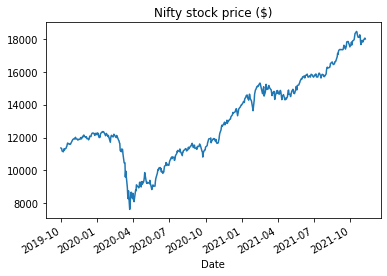

In [3]:
nifty_df = yf.download('^nsei',start='2019-10-01')
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [4]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [5]:
df = nifty_df[['Adj Close']]


mean 15924.394186153108


Text(0.5, 0, 'Days')

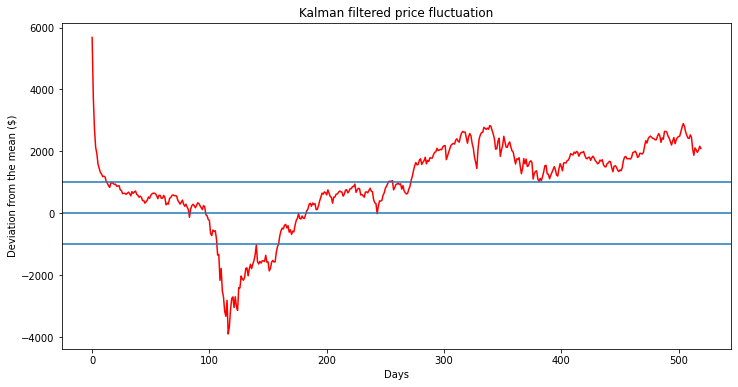

In [6]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')


plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [7]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [8]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(append=True)

print()

In [9]:
nifty=nifty.set_index('date')

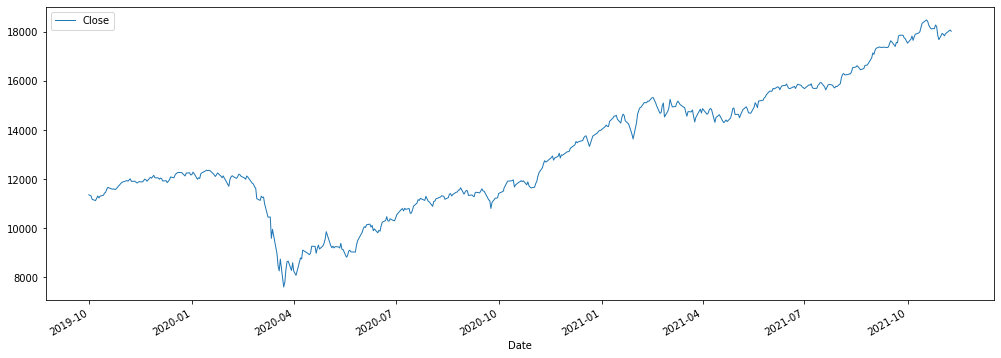

In [10]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

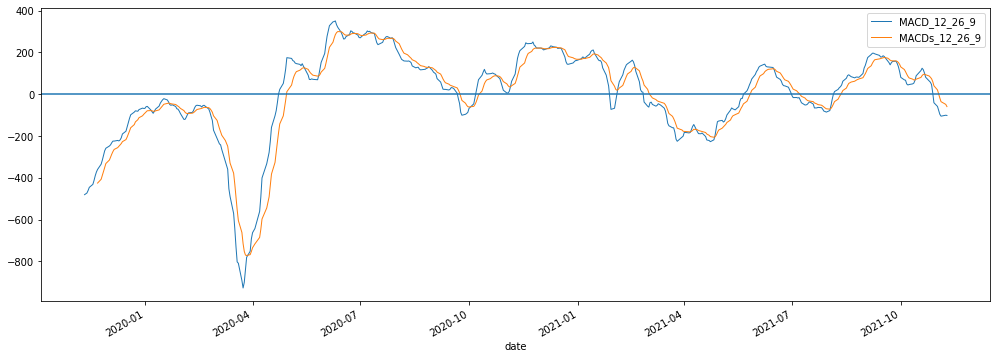

In [11]:
nifty[['MACD_12_26_9','MACDs_12_26_9']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

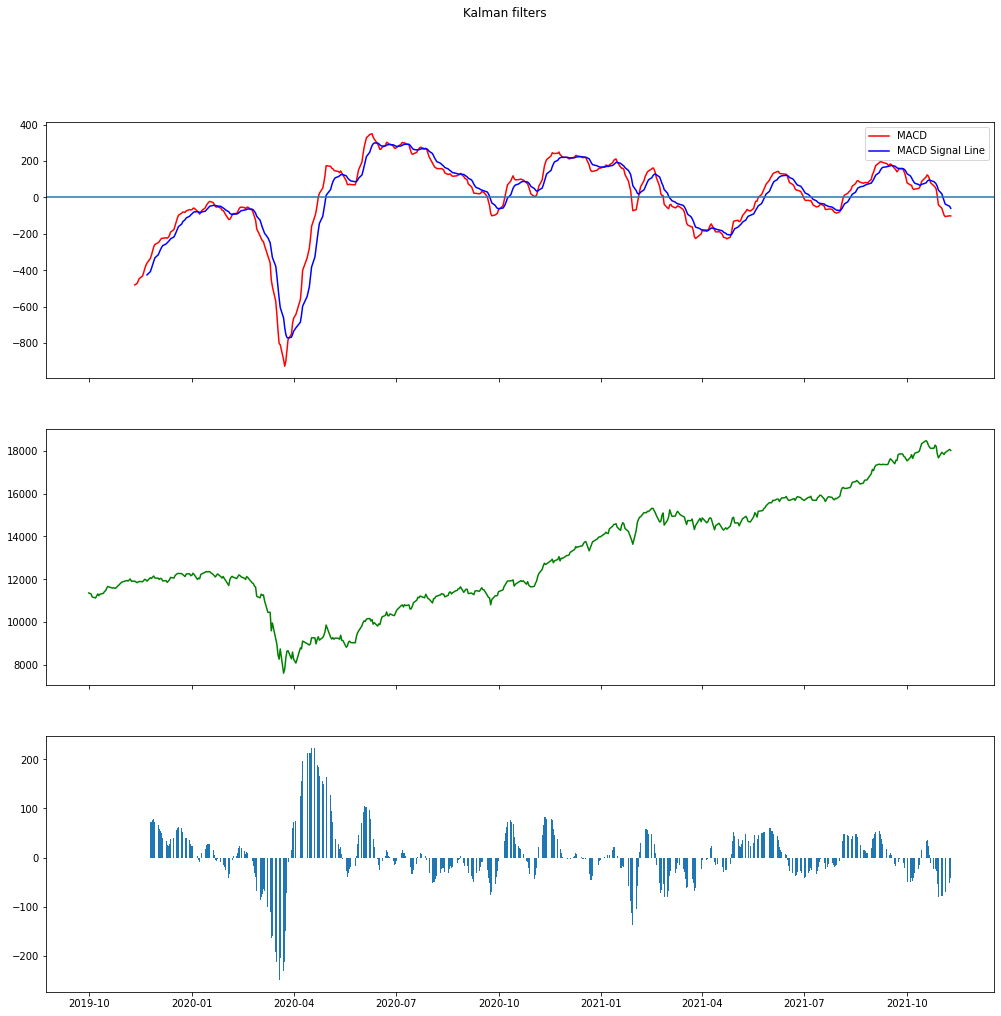

In [12]:
fig, ax = plt.subplots(3,1,figsize=(17,16),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_12_26_9'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_12_26_9'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_12_26_9'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[0].legend()
plt.show()


In [13]:
nifty['signals']=0

for i in range(len(df)):
  if nifty['MACD_12_26_9'].iloc[i]>nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]<nifty['MACDs_12_26_9'].iloc[i-1]:
    nifty['signals'].iloc[i]=1
  elif nifty['MACD_12_26_9'].iloc[i]<nifty['MACDs_12_26_9'].iloc[i] and nifty['MACD_12_26_9'].iloc[i-1]>nifty['MACDs_12_26_9'].iloc[i-1]:
    nifty['signals'].iloc[i]=-1  
 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [14]:
nifty['signals'].value_counts()

 0    481
-1     20
 1     19
Name: signals, dtype: int64

In [15]:
nifty[nifty['signals']==-1].tail(3)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,signals
date,,,,,,,,,
2021-06-16,1877.268997,1830.836486,168.458864,1915.065918,1746.607054,116.437817,-4.651031,121.088848,-1
2021-09-20,2291.186079,2278.974299,234.844089,2396.396343,2161.552254,158.837962,-13.562235,172.400196,-1
2021-10-22,2429.357203,2511.088253,185.243630,2603.710068,2418.466438,81.060327,-11.996017,93.056345,-1


In [16]:
nifty[nifty['signals']==1].index[-1]

Timestamp('2021-10-14 00:00:00')

In [17]:
nifty[nifty['signals']==-1].index[-1]

Timestamp('2021-10-22 00:00:00')

In [18]:
if nifty['signals'].iloc[-1]!=0:
  var=nifty['signals'].iloc[-1]
  print(f'Signal Changed to {var}')
else:
  print(f'no change in signals')
  print(f'last buy signal              last sell signal')
  print(nifty[nifty['signals']==1].index[-1],'::::::::',nifty[nifty['signals']==-1].index[-1])

no change in signals
last buy signal              last sell signal
2021-10-14 00:00:00 :::::::: 2021-10-22 00:00:00


In [19]:
nifty['signals_zeroline']=np.where(nifty['MACD_12_26_9']>0,1,-1)

In [20]:
nifty['sum']=nifty['signals']+nifty['signals_zeroline']

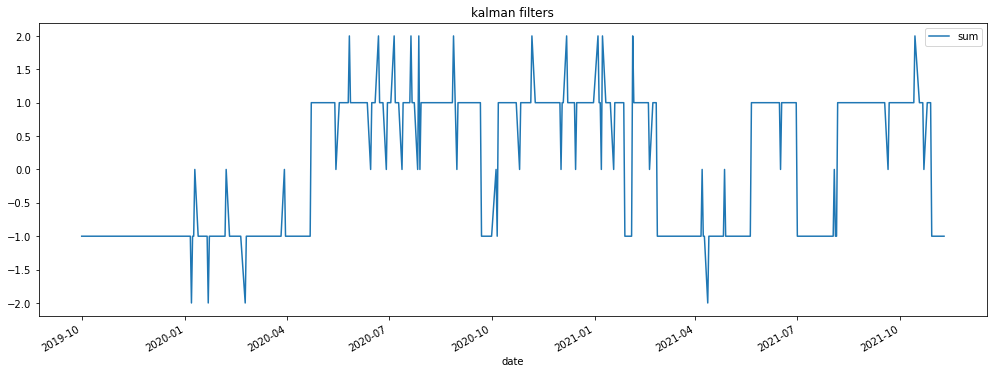

In [21]:
nifty['sum'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

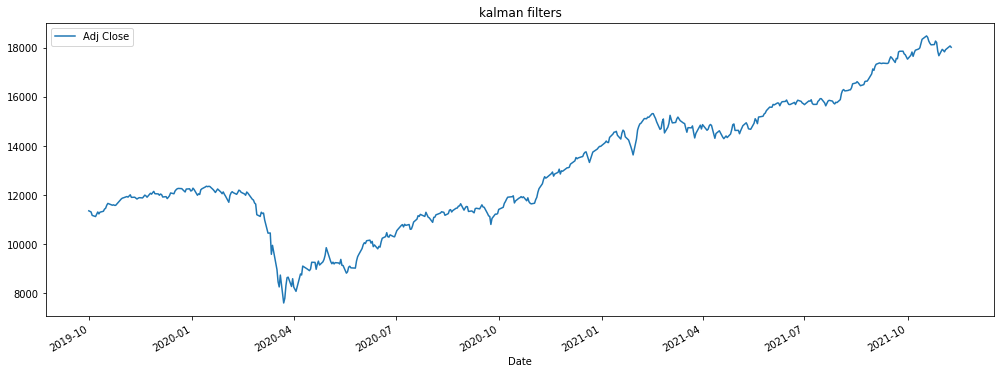

In [22]:
df['Adj Close'].plot(kind='line',figsize=(17,6),legend=True,title='kalman filters');

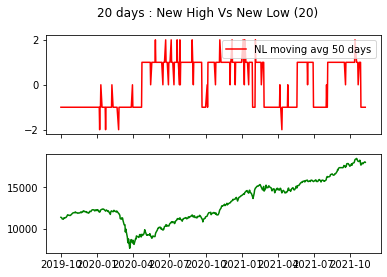

In [23]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


In [24]:
nifty['sum']=np.where(nifty['sum']>=0,1,-1)

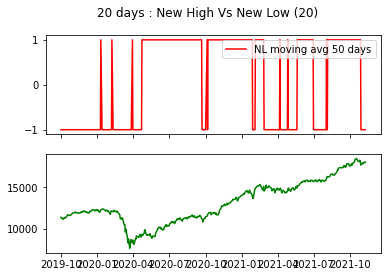

In [25]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'sum'],'r', label='NL moving avg 50 days')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='NH moving avg 50 days')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('20 days : New High Vs New Low (20)')
ax[0].legend()
plt.show()


In [26]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,signals,signals_zeroline,sum
date,,,,,,,,,,,
2021-11-08,2165.175745,2389.759215,298.191791,2538.855111,2240.663320,-100.573215,-51.885510,-48.687704,0,-1,-1
2021-11-09,2091.305033,2371.944102,305.116844,2524.502524,2219.385681,-101.739199,-42.441196,-59.298003,0,-1,-1


In [27]:
nifty['sum'].to_csv('kalman.csv')